In [ ]:
# n_participants + N_INCIDENTS_FOR_THAT_WEEK

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import mapply
mapply.init(n_workers=7, progressbar=True)


# Read in the data
final = pd.read_csv('./dataset/data/final_clean3.csv')

final.columns

final.shape

final.head()




,date_year,date_month,state,incident_characteristics1,congressional_district,date_day,city_or_county,latitude,longitude,min_age_participants,...,cd_month_SHOT_DEAD,cd_month_NON_SHOOTING,cd_month_SHOTS_FIRED_UNHARMED,cd_month_OTHER,state_month_SHOT_INJURED,state_month_SHOT_DEAD,state_month_NON_SHOOTING,state_month_SHOTS_FIRED_UNHARMED,state_month_OTHER,non_workday
0,2013.0,1,CALIFORNIA,SHOT_INJURED,43.0,1,Hawthorne,33.9090,-118.3330,20.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
1,2013.0,1,COLORADO,SHOT_DEAD,6.0,5,Aurora,39.6518,-104.8020,29.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
2,2013.0,1,LOUISIANA,SHOT_INJURED,2.0,21,New Orleans,29.9435,-90.0836,16.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
3,2013.0,1,LOUISIANA,SHOT_INJURED,3.0,26,Charenton,29.8816,-91.5251,48.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
4,2013.0,1,MARYLAND,SHOT_INJURED,7.0,23,Baltimore,39.2899,-76.6412,15.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0


In [4]:
#filter only for accidents  between 2014 and 2017
final_wout_wrng_years = final[(final['date_year'] >= 2014) & (final['date_year'] <= 2017)].copy()


## Dataframe with only the correct years for timeseries
final_wout_wrng_years.shape

final_wout_wrng_years.columns

# make a new column with the week number from timestamp//7 - number of weeks from 2010-01-01

final_wout_wrng_years['week_number'] = (final_wout_wrng_years['timestamp']//7) - 208

final_wout_wrng_years['week_number'] = final_wout_wrng_years['week_number'].astype(int)

In [5]:
#sort by week using date_year, date_month, date_day
city_df = final_wout_wrng_years.sort_values(by=['week_number']).copy()
city_df

#boston = city_df[city_df['city_or_county'] == 'Boston'].copy()



#create a new dataframe with 3 colums: week_number, city, number of accidents per week

cool_df = city_df.groupby(['week_number', 'city_or_county']).size().reset_index(name='counts')
#cool_df

#pivot the table to have the cities as columns
pivot_df = cool_df.pivot(index='week_number', columns='city_or_county', values='counts')
#pivot_df

#fill the NaN values with 0
pivot_df = pivot_df.fillna(0)
pivot_df

#make them integers
pivot_df = pivot_df.astype(int)
pivot_df


city_or_county,Abbeville,Abbotsford,Abbott,Abbott Township,Abbottstown,Abercrombie,Aberdeen,Abilene,Abingdon,Abington,...,Zion,Zion (Beach Park),Zion Grove,Zionsville,Zionville,Zumbro Falls,Zumbrota,Zuni (Zuni Pueblo),Zwolle,jefferson parish (county)
week_number,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
205,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
206,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
#remove the colums with less than 15% of 208 weeks
pivot_df = pivot_df.loc[:, (pivot_df.sum(axis=0) > 30)]
pivot_df

#give me the list of cities remaining
pivot_df.columns



final_pivot = pivot_df.copy()

#remove from city_df the cities that are not in the pivot_df
clean_city_df = city_df[city_df['city_or_county'].isin(final_pivot.columns)].copy()




In [7]:
clean_city_df.groupby(['city_or_county'])["n_killed"].sum().sort_values(ascending=True)


city_or_county
Oil City (Caddo)       1.0
Meriden                1.0
Janesville             2.0
Fulton                 2.0
Framingham             2.0
                     ...  
Philadelphia         877.0
Saint Louis          904.0
Baltimore           1042.0
Houston             1169.0
Chicago             2093.0
Name: n_killed, Length: 790, dtype: float64

In [70]:
TO_RENAME = clean_city_df.copy()


incidents_city_week = TO_RENAME.groupby(['week_number', 'city_or_county']).size()
#incidents_city_week

n_participants_city_week = TO_RENAME.groupby(['week_number', 'city_or_county'])['n_participants'].sum()


TO_RENAME = TO_RENAME.set_index(['week_number','city_or_county'])


def score(df: pd.DataFrame):
    return incidents_city_week.loc[df.name] + n_participants_city_week.loc[df.name]

TO_RENAME['score'] = TO_RENAME.groupby(TO_RENAME.index.names).apply(score)
#TO_RENAME['score'] = TO_RENAME.groupby(TO_RENAME.index.names)['n_killed'].sum()
TO_RENAME['label'] = TO_RENAME.groupby(TO_RENAME.index.names)['n_killed'].sum().apply(lambda x: 1 if x > 0 else 0).astype(int)



score_pivot = TO_RENAME.pivot_table(index='week_number', columns='city_or_county', values='score')
score_pivot = score_pivot.fillna(0)

label_pivot = TO_RENAME.pivot_table(index='week_number', columns='city_or_county', values='label')
label_pivot = label_pivot.fillna(0)


In [71]:
# We keep this for historical reasons (PC+4)
threshold = 1

city_label = label_pivot.sum(axis=0) 
city_label.sort_values(ascending=False).median()

city_label = city_label > city_label.median() - 1

city_label.value_counts()

True     397
False    393
Name: count, dtype: int64

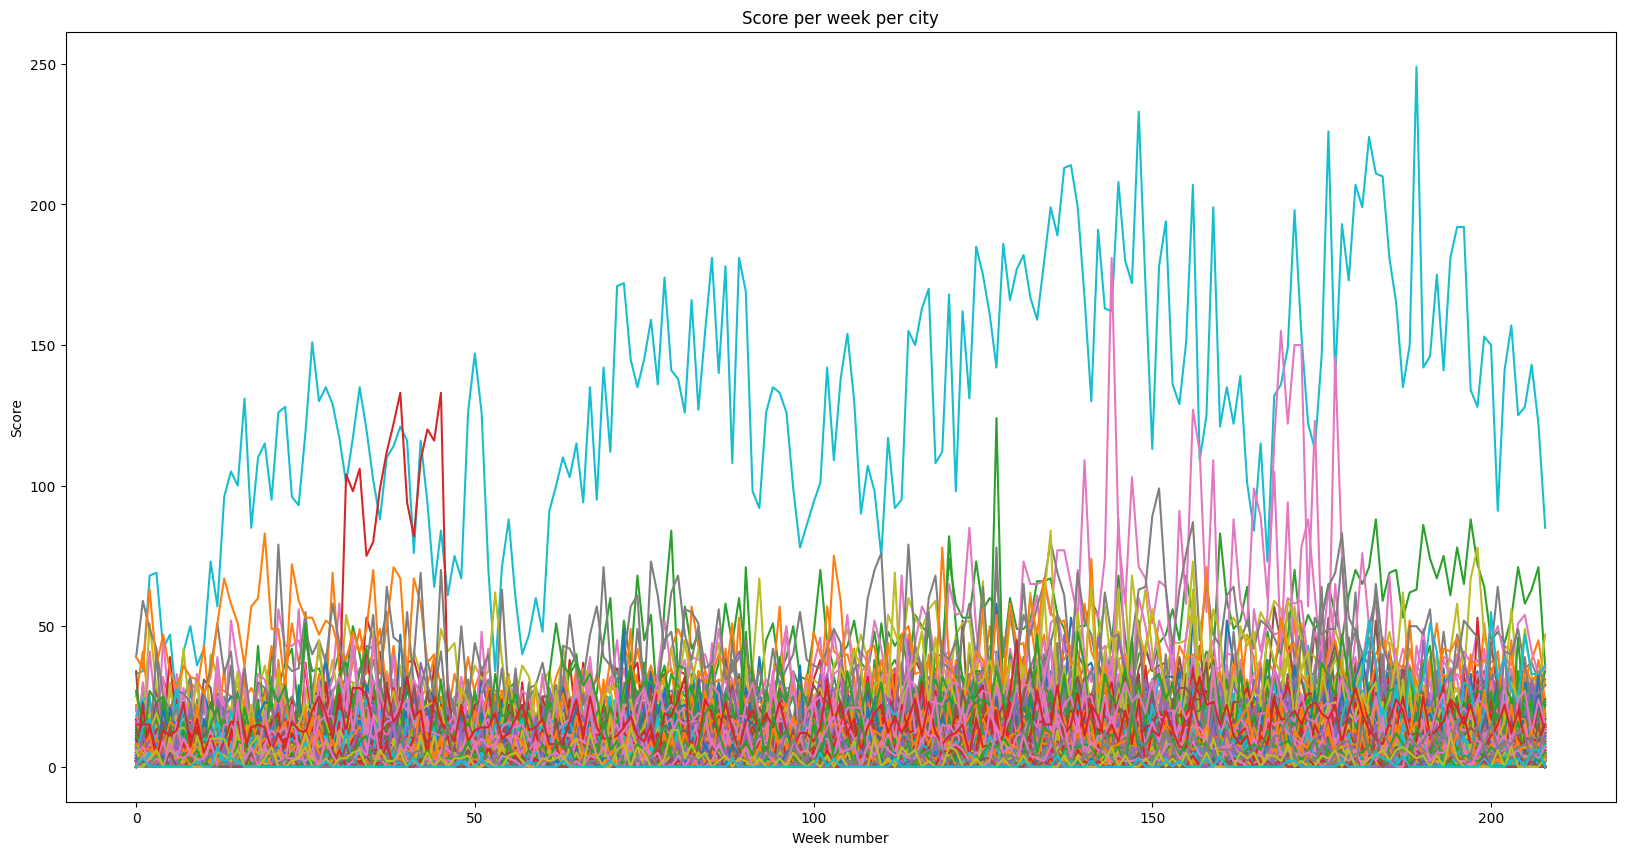

In [72]:

score_pivot.plot(figsize=(20,10), legend=False)
plt.title('Score per week per city')
plt.xlabel('Week number')
plt.ylabel('Score')
plt.show()




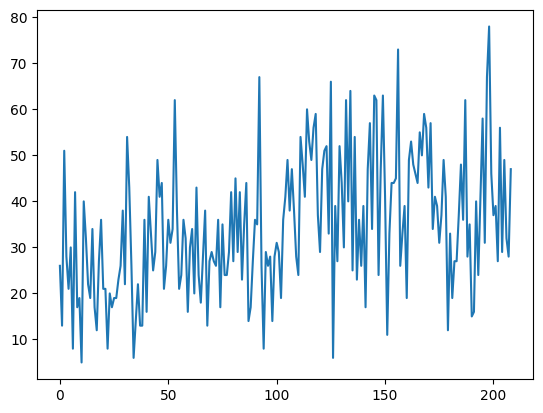

In [73]:
ts1 = pd.Series(score_pivot['Houston'])
plt.plot(ts1)
plt.show()

---

In [75]:
#from tensorflow.keras.optimizers import Adagrad
#from tslearn.shapelets import ShapeletModel
#from tslearn.shapelets import grabocka_params_to_shapelet_size_dict

X = score_pivot.values.T
y = city_label.values

from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesScalerMeanVariance

scaler_1 = TimeSeriesScalerMeanVariance(0, 1)

X = scaler_1.fit_transform(X)[:,:,0]

# scaler_2 = TimeSeriesScalerMinMax((-1, 1))

# X = scaler_2.fit_transform(X)[:,:,0]

# Compute number and length of shapelets.
# l: Fraction of the length of time series to be used for base shapelet length
# r: Number of different shapelet lengths to use

# return: Dictionary giving, for each shapelet length, the number of such shapelets to be generated


n_ts, ts_sz = X.shape
n_classes = len(set(y))

#
#shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
#                                                       ts_sz=ts_sz,
#                                                       n_classes=n_classes,
#                                                       l=0.1,
#                                                       r=2)
#
#print('n_ts', n_ts)
#print('ts_sz', ts_sz)
#print('n_classes', n_classes)
#print('shapelet_sizes', shapelet_sizes)

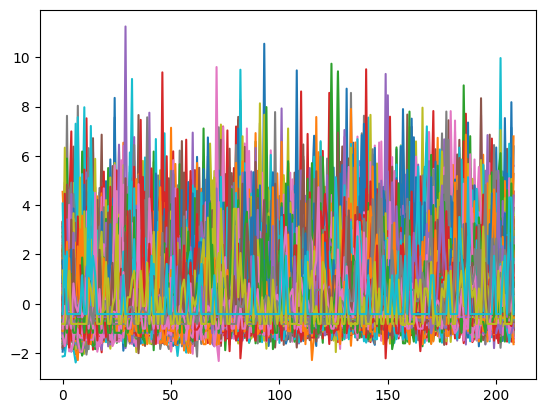

In [76]:
plt.plot(X[:].T)

## test

In [151]:
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer="sgd",
                        weight_regularizer=.01,
                        max_iter=100,
                        verbose=1,
                        scale=False)

shp_clf.fit(X, y)

/home/stefano/Desktop/Big Data Unipi/DM/Project/DataMining-2023/.env9/lib/python3.9/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Epoch 1/100
4/4 [==============================] - 1s 16ms/step - loss: 0.7025 - binary_accuracy: 0.5025 - binary_crossentropy: 0.6887
Epoch 2/100
4/4 [==============================] - 0s 20ms/step - loss: 0.7024 - binary_accuracy: 0.5051 - binary_crossentropy: 0.6886
Epoch 3/100
4/4 [==============================] - 0s 20ms/step - loss: 0.7024 - binary_accuracy: 0.5063 - binary_crossentropy: 0.6885
Epoch 4/100
4/4 [==============================] - 0s 20ms/step - loss: 0.7023 - binary_accuracy: 0.5101 - binary_crossentropy: 0.6884
Epoch 5/100
4/4 [==============================] - 0s 20ms/step - loss: 0.7022 - binary_accuracy: 0.5127 - binary_crossentropy: 0.6884
Epoch 6/100
4/4 [==============================] - 0s 20ms/step - loss: 0.7021 - binary_accuracy: 0.5152 - binary_crossentropy: 0.6883
Epoch 7/100
4/4 [==============================] - 0s 19ms/step - loss: 0.7020 - binary_accuracy: 0.5165 - binary_crossentropy: 0.6883
Epoch 8/100
4/4 [==============================] - 0s 2

LearningShapelets(max_iter=100, n_shapelets_per_size={20: 5, 40: 5}, verbose=1,
                  weight_regularizer=0.01)

In [152]:
from sklearn.metrics import accuracy_score
predicted_labels = shp_clf.predict(X)
print("Correct classification rate:", accuracy_score(y, predicted_labels))
predicted_locations = shp_clf.locate(X)

4/4 [==============================] - 0s 9ms/step
Correct classification rate: 0.5987341772151898
4/4 [==============================] - 0s 9ms/step


True


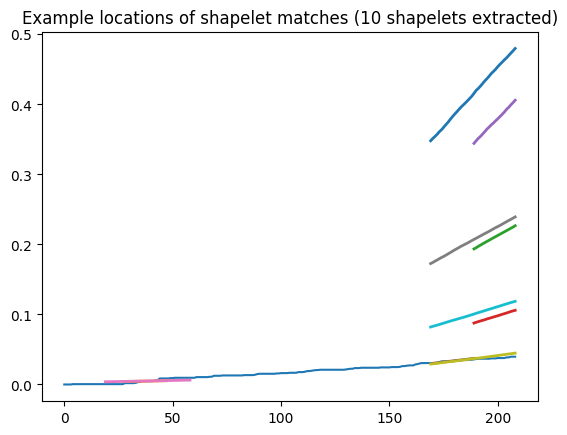

In [156]:
ts_id = 609
plt.figure()
n_shapelets = sum(shapelet_sizes.values())
plt.title(f"""Example locations of shapelet matches ({n_shapelets} shapelets extracted)""")

plt.plot(X[ts_id])
# plt.plot(X[ts_id].ravel())
print(y[ts_id])
for idx_shp, shp in enumerate(shp_clf.shapelets_):
    t0 = predicted_locations[ts_id, idx_shp]
    plt.plot(np.arange(t0, t0 + len(shp)), shp, linewidth=2)

In [98]:
shp_clf.__dict__

{'n_shapelets_per_size': {20: 5, 40: 5, 60: 5, 80: 5, 100: 4},
 'max_iter': 100,
 'batch_size': 256,
 'verbose': 1,
 'optimizer': 'sgd',
 'weight_regularizer': 0.01,
 'shapelet_length': 0.15,
 'total_lengths': 3,
 'max_size': None,
 'scale': True,
 'random_state': None,
 '_min_sz_fit': 209,
 '_X_fit_dims': (790, 209, 1),
 'model_': <keras.src.engine.functional.Functional at 0x7f9b3557e910>,
 'transformer_model_': <keras.src.engine.functional.Functional at 0x7f9b35648160>,
 'locator_model_': <keras.src.engine.functional.Functional at 0x7f9b35594d00>,
 'd_': 1,
 'classes_': array([False,  True]),
 'label_to_ind_': {False: 0, True: 1},
 'n_shapelets_per_size_': {20: 5, 40: 5, 60: 5, 80: 5, 100: 4},
 'history_': {'loss': [0.7085477113723755,
   0.708509087562561,
   0.7084811329841614,
   0.7084481120109558,
   0.708432137966156,
   0.7083738446235657,
   0.7083450555801392,
   0.7082939743995667,
   0.7082383036613464,
   0.7081956267356873,
   0.7081626653671265,
   0.7081319093704224,
 

#  Another method for the Shaplet

In [92]:
import tslearn
from pyts.transformation import ShapeletTransform

# sample only two time series from the dataset

Xy = np.concatenate((X, y.reshape(-1, 1)), axis=1)
Xy = pd.DataFrame(Xy)
Xy = Xy.groupby(209, axis=0).sample(n=25, random_state=1)
X_ = Xy.iloc[:, :-1].values
y_ = Xy.iloc[:, -1].values

print(X.shape)
print(y.shape)
print(X_.shape)
print(y_.shape)

st = ShapeletTransform(n_shapelets=5, window_sizes=[8], n_jobs=-1)
st.fit(X_, y_)

(790, 209)
(790,)
(50, 209)
(50,)


/tmp/ipykernel_110236/3953304715.py:8: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  Xy = Xy.groupby(209, axis=0).sample(n=25, random_state=1)


ShapeletTransform(n_jobs=4, n_shapelets=5, window_sizes=[8])

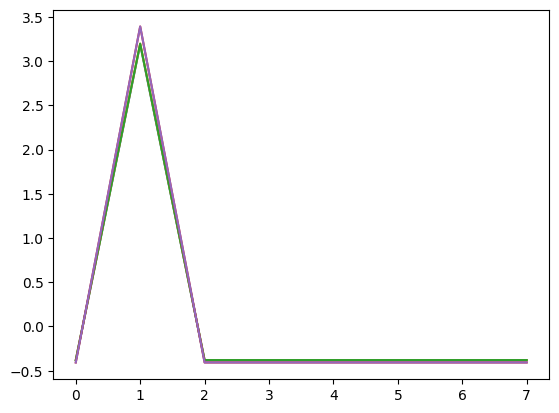

In [93]:
for s in st.shapelets_:
    plt.plot(s)

plt.show()

In [99]:
from pyts.classification import LearningShapelets
shp_clf = LearningShapelets(multi_class='ovo', random_state=42, tol=0.0001, max_iter=5000, verbose=1, n_jobs=9)
shp_clf.fit(X_, y_)

Iteration 0: loss = 0.689978
Iteration 1: loss = 0.671475
Iteration 2: loss = 0.658363
Iteration 3: loss = 0.647539
Iteration 4: loss = 0.637548
Iteration 5: loss = 0.628079
Iteration 6: loss = 0.619017
Iteration 7: loss = 0.610323
Iteration 8: loss = 0.601972
Iteration 9: loss = 0.593946
Iteration 10: loss = 0.586231
Iteration 11: loss = 0.578811
Iteration 12: loss = 0.571672
Iteration 13: loss = 0.564802
Iteration 14: loss = 0.558187
Iteration 15: loss = 0.551817
Iteration 16: loss = 0.545679
Iteration 17: loss = 0.539763
Iteration 18: loss = 0.534058
Iteration 19: loss = 0.528556
Iteration 20: loss = 0.523245
Iteration 21: loss = 0.518119
Iteration 22: loss = 0.513168
Iteration 23: loss = 0.508385
Iteration 24: loss = 0.503762
Iteration 25: loss = 0.499292
Iteration 26: loss = 0.494969
Iteration 27: loss = 0.490785
Iteration 28: loss = 0.486735
Iteration 29: loss = 0.482813
Iteration 30: loss = 0.479014
Iteration 31: loss = 0.475332
Iteration 32: loss = 0.471763
Iteration 33: loss =

LearningShapelets(max_iter=5000, n_jobs=9, random_state=42, tol=0.0001,
                  verbose=1)

              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92        25
         1.0       0.92      0.92      0.92        25

    accuracy                           0.92        50
   macro avg       0.92      0.92      0.92        50
weighted avg       0.92      0.92      0.92        50



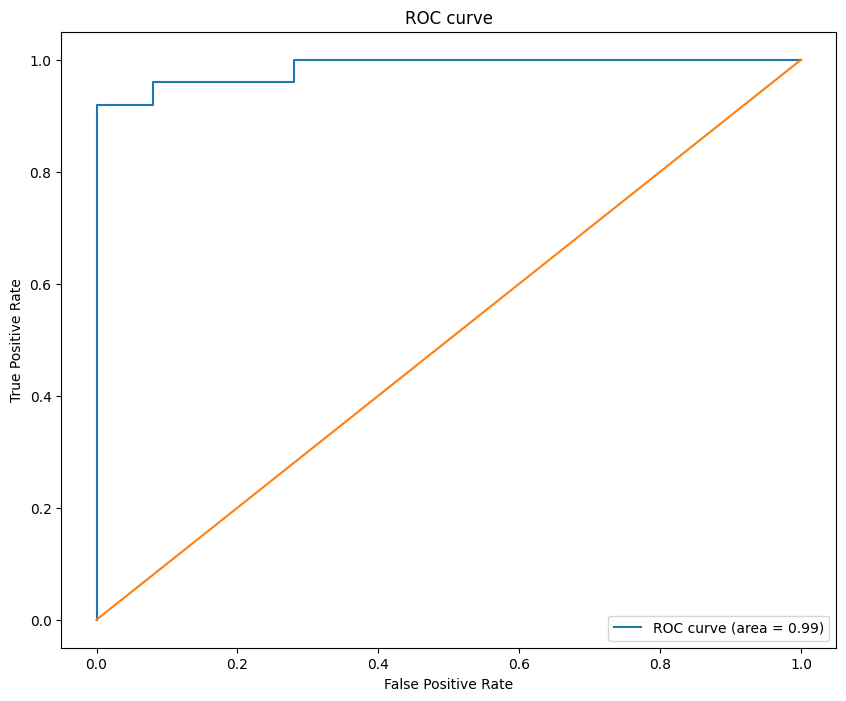

0.92

In [100]:
y_pred = shp_clf.predict(X_)
y_pred_proba = shp_clf.predict_proba(X_)

from sklearn.metrics import classification_report
print(classification_report(y_, y_pred))

# ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()


from sklearn.metrics import accuracy_score
accuracy_score(y_, y_pred)





              precision    recall  f1-score   support

       False       0.81      0.85      0.83       393
        True       0.84      0.81      0.82       397

    accuracy                           0.83       790
   macro avg       0.83      0.83      0.83       790
weighted avg       0.83      0.83      0.83       790



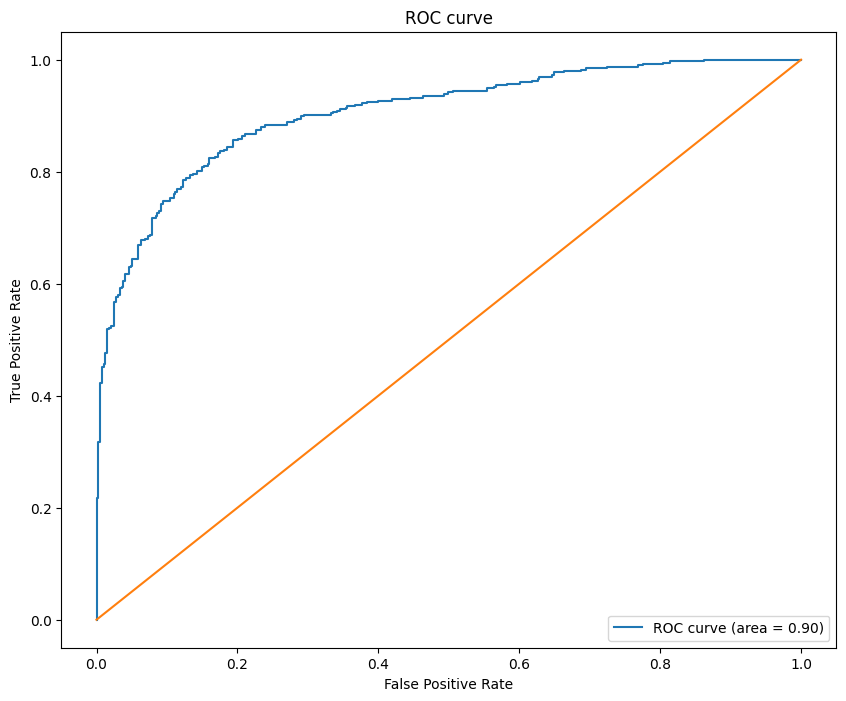

0.8278481012658228

In [101]:
y_pred = shp_clf.predict(X)
y_pred_proba = shp_clf.predict_proba(X)

from sklearn.metrics import classification_report
print(classification_report(y, y_pred))

# ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()


from sklearn.metrics import accuracy_score
accuracy_score(y, y_pred)





In [58]:
shp_clf.coef_.shape

(1, 126)

In [59]:
# Select three shapelets
sel_shapelets = np.asarray([shp_clf.shapelets_[0, 0]]) 

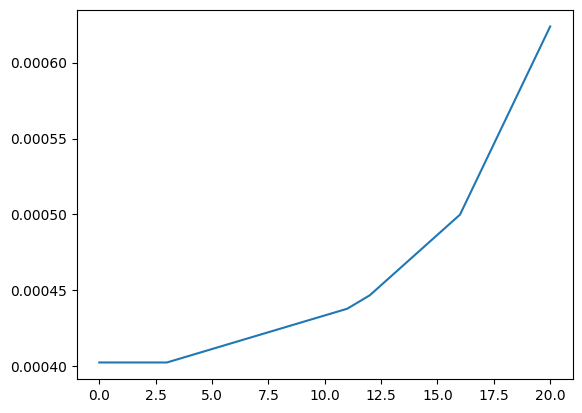

In [60]:
plt.plot(sel_shapelets[0])

plt.show()

In [ ]:
shp_clf.